<h1 align="center">Sentiment Analysis with LSTMs</h1>

First, we need to create word vectors. For simplicity, we will use a pretrained Word2Vec model
with Ukrainian words-vectors, each of which has a dimension of 300.

This sample of word vectors was created on the basis of fiction literature. We chose the lematized version of this model because we already have our sample, which we processed in the previous part, which would fit perfectly here.

The model can be found on [this website](https://lang.org.ua/uk/models/).

To get started, let's download the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import pickle
import gensim, logging
import gensim.models.keyedvectors as word2vec
import matplotlib.pyplot as plt

%matplotlib inline

Also let's write a style for alignment in the middle of all graphs, images, etc:

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Next, we will load the sample data we processed in the previous part:

In [3]:
with open('documents.pql', 'rb') as f:
     docs = pickle.load(f)

In [4]:
print("Number of documents:", len(docs))

Number of documents: 1997


Now we will load our word2vec model. 

This may take some time, as the model contains 325 250  words, so we will get a 325 250 x 300 embedding matrix that contains all the values of the word vectors.

In [5]:
model = word2vec.KeyedVectors.load_word2vec_format('ubercorpus.lowercased.lemmatized.word2vec.300d.txt', binary=False)

Now let's get a list of all the words from our dictionary:

In [6]:
words = list(model.vocab)

Just to make sure everything is loaded correctly, we can look at the dimensions of the dictionary list and the embedding matrix:

In [7]:
print(words[:50], "\n\nTotal words:", len(words), "\n\nWord-Vectors shape:", model.vectors.shape)

['в', 'на', 'у', 'і', 'з', 'що', 'не', 'бути', 'до', 'за', 'та', 'це', 'україна', 'який', 'як', 'про', 'рік', 'а', 'він', 'для', 'від', 'свій', 'вони', 'його', 'цей', 'також', 'я', 'ми', 'той', 'й', 'категорія', 'один', 'мати', 'час', 'такий', 'із', 'але', 'могти', 'під', 'рок', 'президент', 'по', 'те', 'вона', 'після', 'сказати', 'країна', 'український', 'інший', 'так'] 

Total words: 325250 

Word-Vectors shape: (325250, 300)


We can also find a word like "гарний" in our word list and then access the corresponding vector through the embedding matrix:

In [8]:
print(model['гарний'])

[ 4.516500e-02  1.251880e-01  2.108905e+00  1.637814e+00 -4.077700e-02
  7.728100e-01 -6.516440e-01  1.463697e+00  3.339670e-01 -6.916780e-01
 -1.779990e-01  4.337260e-01  7.660550e-01  9.300980e-01 -1.599930e-01
  2.290509e+00 -5.549170e-01  6.714390e-01 -4.648900e-02 -2.138202e+00
  8.052800e-02  7.673460e-01 -2.694449e+00 -2.138186e+00  6.990550e-01
 -2.908490e-01 -4.759980e-01 -1.400164e+00 -1.804889e+00 -7.014440e-01
 -1.354321e+00 -4.605037e+00 -2.812303e+00  1.006020e+00 -4.980150e-01
  7.537600e-01 -2.421496e+00  2.177093e+00 -1.282774e+00  2.158463e+00
  5.019600e-01 -1.288280e-01 -1.434353e+00  1.179314e+00 -4.570560e-01
  1.129010e-01  3.679680e-01  1.147463e+00 -2.718560e-01 -4.053980e-01
 -1.606960e+00 -1.048291e+00 -1.496587e+00  1.050120e-01 -4.461910e-01
 -6.268950e-01  1.559451e+00  4.125400e-02 -5.025610e-01 -4.405390e-01
  5.498720e-01  6.160980e-01 -1.434053e+00 -3.693590e-01  9.504800e-01
  5.033900e-02  6.530420e-01  1.092300e-01  1.099505e+00 -5.173930e-01
  4.52

<h2 align="center">Word Average Embedding Model</h2>

Well, let's start analyzing our vectors. Our first approach will be the **word average embedding model**. 

The essence of this naive approach is to take the average of all word vectors from a sentence to get one 300-dimensional vector that represents the tone of the whole sentence that we feed the model and try to get some quick result.

We didn't have to put a try/except, but even though I cleaned up our sample, there were a couple of hundred words left after the processing that needed to be searched for and removed, such as `жорда`, `дарба`, `еріот`, `енрон`. These are not even words, so their absence will not affect anything.

In [9]:
def sent_embed(words, docs):
    x_sent_embed, y_sent_embed = [], []
    count_words, count_non_words = 0, 0  
    
    # recover the embedding of each sentence with the average of the vector that composes it
    # sent - sentence, state - state of the sentence (pos/neg)
    for sent, state in docs:
        # average embedding of all words in a sentence
        sent_embed = []
        for word in sent:
            try:
                count_words += 1
                sent_embed.append(model[word])
            except KeyError:
                count_non_words += 1
                sent_embed.append(0)
        
        # add a sentence vector to the list
        x_sent_embed.append(np.mean(sent_embed, axis=0).tolist())
        
        # add a label to y_sent_embed
        if state == 'pos': y_sent_embed.append(1)
        elif state == 'neg': y_sent_embed.append(0)
            
    print(count_non_words, "out of", count_words, "words were not found in the vocabulary.")
    
    return x_sent_embed, y_sent_embed

In [42]:
x, y = sent_embed(words, docs)

2986 out of 141899 words were not found in the vocabulary.


<h2 align="center">Cosine Similarity</h2>

To measure the similarity of 2 words, we need a way to measure the degree of similarity between 2 embedding vectors for these 2 words. Given 2 vectors $u$ and $v$, cosine similarity is determined as follows:

$$\text{cosine_similarity(u, v)} = \frac {u . v} {||u||_2 ||v||_2} = cos(\theta)$$

where: 

* $u.v$ - dot product (or inner product) of two vectors;

* $||u||_2$ - norm (or length) of the vector $u$;
    
    * **Note**: norm of $u$ is defined as $ ||u||_2 = \sqrt{\sum_{i=1}^{n} u_i^2}$)

* $\theta$ is the angle between $u$ and $v$. 

This similarity depends on the angle between $u$ and $v$. If $u$ and $v$ are very similar, their cosine similarity will be close to 1; if they are dissimilar, the cosine similarity will take a smaller value. 

**`cosine_similarity()`** is a method that used to estimate the similarity between word vectors.

In [11]:
def cosine_similarity(u, v):
    """
    Cosine similarity reflects the degree of similariy between u and v
        
    Arguments:
        u -- a word vector of shape (n,)          
        v -- a word vector of shape (n,)

    Returns:
        cosine_similarity -- the cosine similarity between u and v defined by the formula above.
    """
    
    distance = 0.0
    
    # compute the dot product between u and v
    dot = np.dot(u,v)
    
    # compute the L2 norm of u
    norm_u = np.sqrt(sum(u**2))
    
    # Compute the L2 norm of v
    norm_v = np.sqrt(sum(v**2))
    
    # Compute the cosine similarity defined by formula above
    cosine_similarity = dot/(norm_u*norm_v)
    
    return cosine_similarity

Let's check the cosine similarity on 2 negative sentences:

In [12]:
print("Sentence #6: ", docs[6], "\n\nSentence #7: ", docs[7])
print("\nSentence Embedding #6: ", x[6], "\n\nSentence Embedding #7: ", x[7])

Sentence #6:  (['весь', 'книга', 'читатися', 'стаття', 'клас', 'починаючи', 'незліченний', 'кількість', 'граматичний', 'орфографічний', 'помилка', 'закінчуючи', 'повторюваний', 'речення', 'буквально', 'цитуючи', 'передрукований', 'слово', 'слово', 'сторінка', 'окремо', 'важко', 'дратуватися', 'читаючи', 'інформація', 'чудовий', 'автор', 'відхилятися', 'зосередження', 'увага', 'група', 'давати', 'інформація', 'найзапекліший', 'фанат', 'піклуватися', 'жаль', 'єдиний', 'книга', 'виходити', 'хотіти', 'дізнатися', 'гурт', 'форма', 'книга', 'пропонувати', 'переглянути', 'офіційний', 'сайт', 'очевидно', 'автор', 'отримати', 'інформація', 'витрачати', 'гроші'], 'neg') 

Sentence #7:  (['чесно', 'кажучи', 'вважати', 'книга', 'нудний', 'повторюваний', 'основний', 'зауваження', 'автор', 'цікавий', 'увійти', 'нарис', 'крім', 'конкретний', 'відбиток', 'книга', 'придбати', 'обкладинка', 'собака', 'очікувати', 'книга', 'зосереджуватися', 'поведінка', 'собака', 'натомість', 'відчувати', 'обдурити', 'н

In [13]:
print("cosine_similarity = ", cosine_similarity(np.array(x[6]), np.array(x[7])))

cosine_similarity =  0.6968024793379766


A value of 0.7 indicates that the sentences are close to each other, and so it is.

Let's check on two positive sentences:

In [14]:
print("Sentence #0: ", docs[0], "\n\nSentence #3: ", docs[3])
print("\nSentence Embedding #0: ", x[0], "\n\nSentence Embedding #3: ", x[3])

Sentence #0:  (['засуджувати', 'книга', 'довгий', 'нудний', 'список', 'походження', 'значення', "ім'я", 'вийти', 'мода', 'сучасний', 'діти', 'втрачати', 'сенс', 'веселий', 'читабельний', 'керівництво', 'називати', 'діти', 'включаючи', 'відомий', 'тезка', 'святий', 'папа', 'президент', 'роялті', 'музика', 'кінозірка', 'знаменитість', 'назвати', 'діти', 'також', 'захоплюючий', 'читати', 'певний', "ім'я", 'вийти', 'мода', 'наприклад', 'ліза', 'сьюзен', 'світанок', 'популярний', 'немовля', 'народжений', 'однокласник', 'рідко', 'використовуватися', 'основний', 'вада', 'книга', 'полягати', 'батьки', 'визнати', 'батьки', 'називати', 'діти', 'прізвище', 'люди', 'захоплюватися', "ім'я", 'один', 'написати', 'гаррісон', 'форд', 'напевно', 'причина', 'популярність', "ім'я", 'гаррісон', 'вибачити', 'чути', 'бітлз', 'запис', 'назва', 'джордан', 'згадуватися', 'майкл', 'джордан', 'безумовно', 'головний', 'натхнення', "ім'я", 'область', 'запис', 'джексон', 'згадуватися', 'майкл', 'джанет', 'семюель', 

In [15]:
print("cosine_similarity = ", cosine_similarity(np.array(x[0]), np.array(x[3])))

cosine_similarity =  0.7003299414571339


These sentences are also close to each other. 

So now let's check sentences with different states:

In [16]:
print("Sentence #1: ", docs[1], "\n\nSentence #2: ", docs[2])

Sentence #1:  (['вибачити', 'ненавидіти', 'нагромаджувати', 'повинний', 'погодитися', 'учитель', 'мислення', 'недбалий', 'суперечливий', 'написання', 'дерево', 'яний', 'жорсткий', 'дратівливий', 'купити', 'місяць', 'сховати', 'шухляда', 'змогти', 'обійти', 'витягнути', 'посмішка', 'великий', 'надія', 'хлопчик', 'розчарований', 'подумати', 'можливо', 'поганий', 'день', 'можливо', 'концентрація', 'зниклий', 'витягнути', 'трумен', 'капот', 'гладкий', 'шовк', 'вино', 'рона', 'нарешті', 'вирішити', 'відсканувати', 'книга', 'виявити', 'насправді', 'новий', 'цікавий', 'хотіти', 'витратити', 'даремно', 'гріш', 'повинний', 'обережніший', 'стосуватися', 'книга', 'мати', 'посилання', 'класти', 'смітник', 'суботній', 'вечір', 'вони', 'прийти', 'понеділок', 'забрати', 'сміття', 'роджер'], 'neg') 

Sentence #2:  (['книга', 'починатися', 'основа', 'атомний', 'будова', 'спиратися', 'теорія', 'молекулярний', 'орбіта', 'молекулярно', 'орбітальний', 'теорія', 'розроблений', 'органічний', 'неорганічний', 

In [17]:
print("cosine_similarity = ", cosine_similarity(np.array(x[1]), np.array(x[2])))

cosine_similarity =  0.3296801638645647


Here the similarity is extremely small, which means that the sentences are not similar to each other.

<h2 align="center">Split Corpus</h2>

Now, for further work, we will divide our corpus for training, testing and development sets:

In [18]:
from sklearn.model_selection import train_test_split

# train test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=0)

# train dev
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=0)

In [19]:
print('Length of x_train:', len(x_train), '| Length of y_train:', len(y_train))
print('Length of x_test:  ', len(x_test), '| Length of y_test: ', len(y_test))
print('Length of x_val:   ', len(x_val), '| Length of y_val:  ', len(y_val))

Length of x_train: 1442 | Length of y_train: 1442
Length of x_test:   300 | Length of y_test:  300
Length of x_val:    255 | Length of y_val:   255


In [20]:
print("Shape of x_train set:", np.array(x_train).shape)

Shape of x_train set: (1442, 300)


<h2 align="center">Visualization of Classification Report</h2>

We will need these methods when we start to visualize our data, so we will write them now.

The following function takes the conclusion of the `classification_report` function as an argument and plots the results ( function is based on [this](https://stackoverflow.com/a/31689645/14467732) solution).

In [21]:
def plot_classification_report(classification_report, title='Classification Report', cmap='RdBu'):
    
    lines = classification_report.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    
    for line in lines[2 : (len(lines) - 5)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    xlabel = 'Metrics'
    ylabel = 'Classes'
    
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

This function is designed to create a heatmap with text in each cell using the matplotlib library (code based on idea from [here](https://stackoverflow.com/a/16124677/14467732)):

In [22]:
def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    fig, ax = plt.subplots()
    c = ax.pcolor(AUC, edgecolors='k', linestyle='dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # add color bar
    plt.colorbar(c)

    # add text in each cell 
    show_val(c)

    # proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    fig.set_size_inches(cm_to_inch(figure_width, figure_height))

This function just inserts the text into the cells of the heatmap (idea is taken from [here](https://stackoverflow.com/a/25074150/14467732)):

In [23]:
def show_val(pc, fmt="%.2f", **kw):
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

The last auxiliary function is intended to specify the size of the figure in centimeters in matplotlib, because by default there is only the method `set_size_inches`, therefore, we will convert inches to centimeters and use this method:

In [24]:
def cm_to_inch(*dim):
    inch = 2.54
    return tuple(i/inch for i in dim[0]) if type(dim[0]) == tuple else tuple(i/inch for i in dim)

<h2 align="center">KNN Model</h2>

The K-nearest neighbors (KNN) algorithm is a type of supervised machine learning algorithms. KNN is extremely easy to implement in its most basic form, and yet performs quite complex classification tasks.  It is a lazy learning algorithm since it doesn't have a specialized training phase. Rather, it uses all of the data for training while classifying a new data point or instance.  KNN is also a non-parametric learning algorithm, which means that it doesn't assume anything about the underlying data.


KNN  algorithm simply calculates the distance of a new data point to all other training data points. The distance can be of any type e.g Euclidean or Manhattan etc. It then selects the K-nearest data points, where K can be any integer. Finally it assigns the data point to the class to which the majority of the K data points belong.

Now, let's build KNN classifier model.

First, we import the `KNeighborsClassifier` module and create KNN classifier object by passing argument number of neighbors in `KNeighborsClassifier()` function. Then, fit our model on the train set using `fit()` and perform prediction on the test set using `predict()`.

One way to help find the best value of neighbors is to plot the graph of neighbor value and the corresponding error rate for the dataset. We will plot the mean error for the predicted values of test set for all the neighbor values between 1 and 25.
To do so, let's first calculate the mean of error for all the predicted values where neighbor ranges from 1 and 25:

In [25]:
from sklearn.neighbors import KNeighborsClassifier

error = []

# calculating error for neighbor values between 1 and 25
for i in range(1, 25):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    pred_i = knn.predict(x_test)
    error.append(np.mean(pred_i != y_test))

The next step is to plot the error values against neighbor values:

Text(0, 0.5, 'Mean Error')

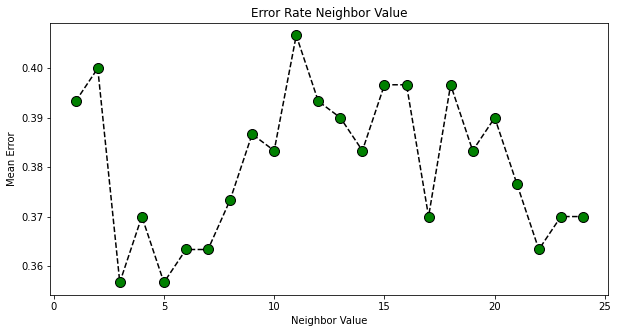

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 25), error, color='black', linestyle='dashed', marker='o', markerfacecolor='green', markersize=10)
plt.title('Error Rate Neighbor Value')
plt.xlabel('Neighbor Value')
plt.ylabel('Mean Error')

As we can see, it is best to take k=5, but still mean error a little higher than normal.

In [27]:
# create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

# train the classifier using the training sets
knn.fit(x_train, y_train)

# predict the response for test dataset
y_pred = knn.predict(x_test)

print("Nearest Neighbors Result (k=5):\n" + '-' * 35)
print("Accuracy Score (k=5):", str(round(knn.score(x_test, y_test), 4) * 100) + '%')
print("Accuracy (x_train, y_train):", str(round(knn.score(x_train, y_train), 4) * 100) + '%')

Nearest Neighbors Result (k=5):
-----------------------------------
Accuracy Score (k=5): 64.33%
Accuracy (x_train, y_train): 100.0%


The accuracy of the model is good, not perfect, but we can work with it.

Now let's explore our KNN Classification results with help of `classification_report` function from sklearn.metrics:

In [28]:
from sklearn.metrics import classification_report
print('\nClassification KNN:\n', classification_report(y_test, knn.predict(x_test)))


Classification KNN:
               precision    recall  f1-score   support

           0       0.60      0.81      0.69       147
           1       0.73      0.48      0.58       153

    accuracy                           0.64       300
   macro avg       0.66      0.65      0.64       300
weighted avg       0.66      0.64      0.63       300



Now finally let's visualize our classification report:

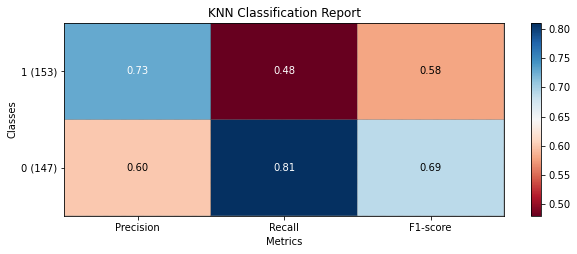

In [29]:
plot_classification_report(classification_report(y_test, knn.predict(x_test)), title='KNN Classification Report')

<h2 align="center">Logistic Regression</h2>

Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

In [30]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(solver='liblinear', multi_class='ovr', n_jobs=1)
logit.fit(x_train, y_train)

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

In [31]:
print("Accuracy Score:", str(round(logit.score(x_test, y_test), 4) * 100) + '%')

Accuracy Score: 70.33%


In [32]:
print('\nClassification Logistic Regression:\n', classification_report(y_test, logit.predict(x_test)))


Classification Logistic Regression:
               precision    recall  f1-score   support

           0       0.69      0.73      0.71       147
           1       0.72      0.68      0.70       153

    accuracy                           0.70       300
   macro avg       0.70      0.70      0.70       300
weighted avg       0.70      0.70      0.70       300



Now let's visualize our classification report:

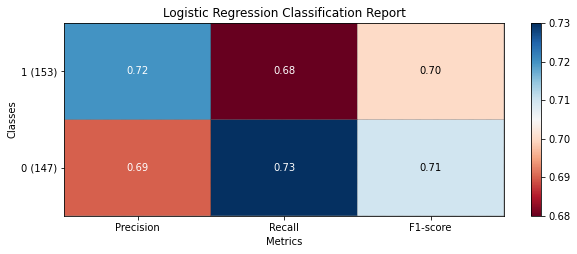

In [33]:
plot_classification_report(classification_report(y_test, logit.predict(x_test)), title='Logistic Regression Classification Report')

<h2 align="center">Random Forest Classifier</h2>

The Random forest or Random Decision Forest is a supervised Machine learning algorithm used for classification, regression, and other tasks using decision trees.

The Random forest classifier creates a set of decision trees from a randomly selected subset of the training set. It is basically a set of decision trees (DT) from a randomly selected subset of the training set and then It collects the votes from different decision trees to decide the final prediction.

In [34]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train, y_train)

print("Accuracy Score:", str(round(clf.score(x_test,y_test), 4) * 100) + '%')

Accuracy Score: 68.67%


In [35]:
print('\nClassification Random Forest:\n', classification_report(y_test, clf.predict(x_test)))


Classification Random Forest:
               precision    recall  f1-score   support

           0       0.67      0.70      0.69       147
           1       0.70      0.67      0.69       153

    accuracy                           0.69       300
   macro avg       0.69      0.69      0.69       300
weighted avg       0.69      0.69      0.69       300



Now let's visualize our classification report:

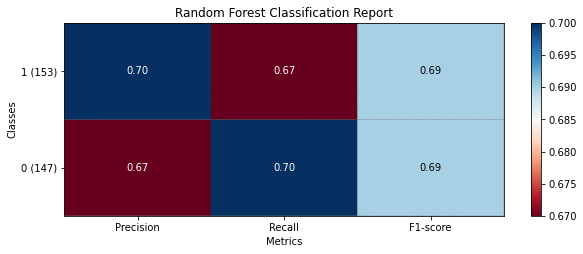

In [36]:
plot_classification_report(classification_report(y_test, clf.predict(x_test)), title='Random Forest Classification Report')

<h2 align="center">Comparison of Models</h2> 

A useful tool when predicting the probability of a binary outcome is the Receiver Operating Characteristic curve, or ROC curve.

It is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0. Put another way, it plots the false alarm rate versus the hit rate.

The true positive rate is calculated as the number of true positives divided by the sum of the number of true positives and the number of false negatives. It describes how good the model is at predicting the positive class when the actual outcome is positive.

The false positive rate is calculated as the number of false positives divided by the sum of the number of false positives and the number of true negatives.

It is also called the false alarm rate as it summarizes how often a positive class is predicted when the actual outcome is negative.

To make this clear:
* Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.
* Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

In [37]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

fprKNN, tprKNN, thresholdsKNN = metrics.roc_curve(y_test, knn.predict_proba(x_test)[:, 1])
fprLR, tprLR, thresholdsLR = metrics.roc_curve(y_test, logit.predict_proba(x_test)[:, 1])
fprCLF, tprCLF, thresholdCLF = metrics.roc_curve(y_test, clf.predict_proba(x_test)[:, 1])

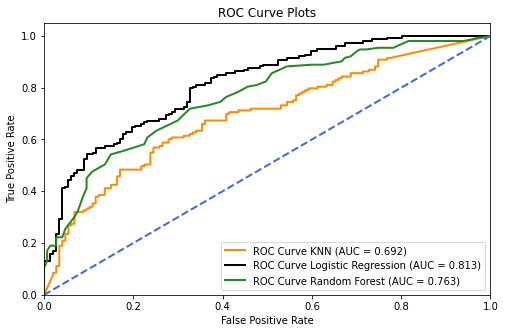

In [38]:
linewidth = 2
plt.figure(figsize=(8, 5))

plt.plot(fprKNN, tprKNN, color='darkorange', lw=linewidth, label='ROC Curve KNN (AUC = %0.3f)' % auc(fprKNN, tprKNN))
plt.plot(fprLR, tprLR, color='black', lw=linewidth, label='ROC Curve Logistic Regression (AUC = %0.3f)' % auc(fprLR, tprLR))
plt.plot(fprCLF, tprCLF, color='forestgreen',lw=linewidth, label='ROC Curve Random Forest (AUC = %0.3f)' % auc(fprCLF, tprCLF))
plt.plot([0, 1], [0, 1], color='royalblue', lw=linewidth, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Plots')
plt.legend(loc="lower right")

plt.show()

Based on these data, we can conclude that the best model so far is a **Logistic Regression Model** with `AUC = 81.3%` and `Accuracy Score = 70.33%`.

Let's save this model:

In [39]:
with open('LogitModel.pickle', 'wb') as m:
    pickle.dump(logit, m)

Let's check if everything is loaded correctly:

In [40]:
with open('LogitModel.pickle', 'rb') as m:
     logit = pickle.load(m)

print("Logistic Regression Accuracy Score:", str(round(logit.score(x_test, y_test), 4) * 100) + '%')

Logistic Regression Accuracy Score: 70.33%


Next we will finally try the **LSTM** neural network, which takes a sequence of words and remembers the order of words in a sentence, this approach should give us the best results.

<h2 align="center">LSTM Model</h2> 
<h3 align="center">Preparation of input data</h3> 

The shape of our sample for training will be `(H, 300, N)`, where:
* `H` - number of samples;
* `300` - dimension of each word; 
* `N` - number of words in each sentence.

For the sake of curiosity, let's analyze how many words are usually found in the reviews:

In [49]:
max_word, min_word = 0, 100
word50, word100, word200, word300, word400  = 0, 0, 0, 0, 0
reviews_len = []

for review, state in docs:
    reviews_len.append(len(review))

    if len(review) > max_word: max_word = len(review)
    if len(review) < min_word: min_word = len(review)

    if len(review) > 50: word50 += 1
    if len(review) > 100: word100 += 1
    if len(review) > 200: word200 += 1
    if len(review) > 300: word300 += 1
    if len(review) > 400: word400 += 1
    
print("Average number of words in the review:", int(sum(reviews_len)/len(reviews_len)))
print("\nMaximum review length:", max_word, "\nMinimum review length:", min_word)
print("\nReview with more than 50 words:", word50, 
      "\nReview with more than 100 words:", word100,
      "\nReview with more than 200 words:", word200, 
      "\nReview with more than 300 words:", word300,
      "\nReview with more than 400 words:", word400)

Average number of words in the review: 71

Maximum review length: 2306 
Minimum review length: 3

Review with more than 50 words: 884 
Review with more than 100 words: 395 
Review with more than 200 words: 115 
Review with more than 300 words: 47 
Review with more than 400 words: 19


Our next function `fix_review_len()` will do a useful job, this function is designed to fix the size of reviews to a fixed size to feed them into a neural network with reviews of a certain length. Reviews whose length is less than fixed will be extended by zeros. This process does not affect the algorithm and reviews longer than the specified length will be truncated.

In [54]:
def fix_review_len(review, length):
    if len(review) > length:
        review = review[:length]
    elif len(review) < length:
        for i in range(length - len(review)):
            zeros = [0] * 300
            review.append(zeros)
    return review

example = [3, 1, 2, 4, 5]
example = fix_review_len(example, 7)
print(example) 

[3, 1, 2, 4, 5, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Now let's update our dataset with word vectors:

In [55]:
x, y = sent_embed(words, docs)

2986 out of 141899 words were not found in the vocabulary.
